## Mga Classifier ng Lutuin 1

Sa araling ito, tatalakayin natin ang iba't ibang classifier upang *hulaan ang isang partikular na pambansang lutuin batay sa isang grupo ng mga sangkap.* Habang ginagawa ito, matututo rin tayo ng iba’t ibang paraan kung paano magagamit ang mga algorithm para sa mga gawain ng klasipikasyon.

### [**Pre-lecture quiz**](https://gray-sand-07a10f403.1.azurestaticapps.net/quiz/21/)

### **Paghahanda**

Ang araling ito ay nakabatay sa ating [nakaraang aralin](https://github.com/microsoft/ML-For-Beginners/blob/main/4-Classification/1-Introduction/solution/lesson_10-R.ipynb) kung saan:

-   Nagkaroon tayo ng maikling pagpapakilala sa klasipikasyon gamit ang isang dataset tungkol sa lahat ng kahanga-hangang lutuin ng Asya at India 😋.

-   Sinuri natin ang ilang [dplyr verbs](https://dplyr.tidyverse.org/) upang ihanda at linisin ang ating data.

-   Gumawa tayo ng magagandang biswal gamit ang ggplot2.

-   Ipinakita kung paano harapin ang hindi balanseng data sa pamamagitan ng pag-preprocess nito gamit ang [recipes](https://recipes.tidymodels.org/articles/Simple_Example.html).

-   Ipinakita kung paano gamitin ang `prep` at `bake` sa ating recipe upang tiyakin na ito ay gagana nang naaayon.

#### **Kinakailangan**

Para sa araling ito, kakailanganin natin ang mga sumusunod na package upang linisin, ihanda, at i-visualize ang ating data:

-   `tidyverse`: Ang [tidyverse](https://www.tidyverse.org/) ay isang [koleksyon ng mga R package](https://www.tidyverse.org/packages) na idinisenyo upang gawing mas mabilis, mas madali, at mas masaya ang data science!

-   `tidymodels`: Ang [tidymodels](https://www.tidymodels.org/) framework ay isang [koleksyon ng mga package](https://www.tidymodels.org/packages/) para sa pagmomodelo at machine learning.

-   `themis`: Ang [themis package](https://themis.tidymodels.org/) ay nagbibigay ng Karagdagang Hakbang sa Recipe para sa Paghawak ng Hindi Balanseng Data.

-   `nnet`: Ang [nnet package](https://cran.r-project.org/web/packages/nnet/nnet.pdf) ay nagbibigay ng mga function para sa pag-estima ng feed-forward neural networks na may isang nakatagong layer, at para sa mga multinomial logistic regression model.

Maaari mo silang mai-install gamit ang:


`install.packages(c("tidyverse", "tidymodels", "DataExplorer", "here"))`

Bilang alternatibo, ang script sa ibaba ay sinusuri kung mayroon kang mga kinakailangang package para makumpleto ang module na ito at ini-install ang mga ito para sa iyo kung kulang.


In [2]:
suppressWarnings(if (!require("pacman"))install.packages("pacman"))

pacman::p_load(tidyverse, tidymodels, themis, here)

Loading required package: pacman



## 1. Hatiin ang data sa training at test sets.

Magsisimula tayo sa pagpili ng ilang hakbang mula sa ating nakaraang aralin.

### Alisin ang mga pinakakaraniwang sangkap na nagdudulot ng kalituhan sa pagitan ng magkakaibang lutuin, gamit ang `dplyr::select()`.

Lahat ay mahilig sa kanin, bawang, at luya!


In [3]:
# Load the original cuisines data
df <- read_csv(file = "https://raw.githubusercontent.com/microsoft/ML-For-Beginners/main/4-Classification/data/cuisines.csv")

# Drop id column, rice, garlic and ginger from our original data set
df_select <- df %>% 
  select(-c(1, rice, garlic, ginger)) %>%
  # Encode cuisine column as categorical
  mutate(cuisine = factor(cuisine))

# Display new data set
df_select %>% 
  slice_head(n = 5)

# Display distribution of cuisines
df_select %>% 
  count(cuisine) %>% 
  arrange(desc(n))

New names:
* `` -> ...1

Rows: 2448 Columns: 385

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): cuisine
dbl (384): ...1, almond, angelica, anise, anise_seed, apple, apple_brandy, a...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



cuisine almond angelica anise anise_seed apple apple_brandy apricot armagnac
1 indian  0      0        0     0          0     0            0       0       
2 indian  1      0        0     0          0     0            0       0       
3 indian  0      0        0     0          0     0            0       0       
4 indian  0      0        0     0          0     0            0       0       
5 indian  0      0        0     0          0     0            0       0       
  artemisia ⋯ whiskey white_bread white_wine whole_grain_wheat_flour wine wood
1 0         ⋯ 0       0           0          0                       0    0   
2 0         ⋯ 0       0           0          0                       0    0   
3 0         ⋯ 0       0           0          0                       0    0   
4 0         ⋯ 0       0           0          0                       0    0   
5 0         ⋯ 0       0           0          0                       0    0   
  yam yeast yogurt zucchini
1 0   0     0      0       
2 0   0     0      0       
3 0   0     0      0       
4 0   0     0      0       
5 0   0     1      0

cuisine  n  
1 korean   799
2 indian   598
3 chinese  442
4 japanese 320
5 thai     289

Perfecto! Ngayon, oras na para hatiin ang data kung saan 70% ng data ay mapupunta sa training at 30% naman sa testing. Gagamit din tayo ng `stratification` na teknika kapag hinati ang data upang `mapanatili ang proporsyon ng bawat cuisine` sa training at validation datasets.

Ang [rsample](https://rsample.tidymodels.org/), isang package sa Tidymodels, ay nagbibigay ng imprastraktura para sa epektibong paghahati at pag-resample ng data:


In [4]:
# Load the core Tidymodels packages into R session
library(tidymodels)

# Create split specification
set.seed(2056)
cuisines_split <- initial_split(data = df_select,
                                strata = cuisine,
                                prop = 0.7)

# Extract the data in each split
cuisines_train <- training(cuisines_split)
cuisines_test <- testing(cuisines_split)

# Print the number of cases in each split
cat("Training cases: ", nrow(cuisines_train), "\n",
    "Test cases: ", nrow(cuisines_test), sep = "")

# Display the first few rows of the training set
cuisines_train %>% 
  slice_head(n = 5)


# Display distribution of cuisines in the training set
cuisines_train %>% 
  count(cuisine) %>% 
  arrange(desc(n))

Training cases: 1712
Test cases: 736

cuisine almond angelica anise anise_seed apple apple_brandy apricot armagnac
1 chinese 0      0        0     0          0     0            0       0       
2 chinese 0      0        0     0          0     0            0       0       
3 chinese 0      0        0     0          0     0            0       0       
4 chinese 0      0        0     0          0     0            0       0       
5 chinese 0      0        0     0          0     0            0       0       
  artemisia ⋯ whiskey white_bread white_wine whole_grain_wheat_flour wine wood
1 0         ⋯ 0       0           0          0                       1    0   
2 0         ⋯ 0       0           0          0                       1    0   
3 0         ⋯ 0       0           0          0                       0    0   
4 0         ⋯ 0       0           0          0                       0    0   
5 0         ⋯ 0       0           0          0                       0    0   
  yam yeast yogurt zucchini
1 0   0     0      0       
2 0   0     0      0       
3 0   0     0      0       
4 0   0     0      0       
5 0   0     0      0

cuisine  n  
1 korean   559
2 indian   418
3 chinese  309
4 japanese 224
5 thai     202

## 2. Paano Harapin ang Hindi Balanseng Datos

Tulad ng maaaring napansin mo sa orihinal na data set pati na rin sa ating training set, mayroong hindi pantay na distribusyon sa bilang ng mga lutuin. Ang mga lutuing Koreano ay *halos* 3 beses ang dami kumpara sa mga lutuing Thai. Ang hindi balanseng datos ay madalas na may negatibong epekto sa performance ng modelo. Maraming modelo ang mas mahusay kapag pantay ang bilang ng mga obserbasyon, kaya't nahihirapan ang mga ito kapag hindi balansado ang datos.

May dalawang pangunahing paraan upang harapin ang hindi balanseng data set:

-   magdagdag ng mga obserbasyon sa minority class: `Over-sampling` tulad ng paggamit ng SMOTE algorithm na artipisyal na gumagawa ng mga bagong halimbawa ng minority class gamit ang mga pinakamalapit na kapitbahay ng mga kasong ito.

-   magtanggal ng mga obserbasyon mula sa majority class: `Under-sampling`

Sa ating nakaraang aralin, ipinakita natin kung paano harapin ang hindi balanseng data set gamit ang isang `recipe`. Ang recipe ay maaaring ituring na isang plano na naglalarawan kung anong mga hakbang ang dapat isagawa sa isang data set upang maihanda ito para sa data analysis. Sa ating kaso, nais nating magkaroon ng pantay na distribusyon sa bilang ng ating mga lutuin para sa ating `training set`. Simulan na natin.


In [5]:
# Load themis package for dealing with imbalanced data
library(themis)

# Create a recipe for preprocessing training data
cuisines_recipe <- recipe(cuisine ~ ., data = cuisines_train) %>% 
  step_smote(cuisine)

# Print recipe
cuisines_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor        380

Operations:

SMOTE based on cuisine

Maaari mo nang kumpirmahin (gamit ang prep+bake) na gagana ang recipe ayon sa inaasahan mo - lahat ng mga label ng lutuin ay mayroong `559` na obserbasyon.

Dahil gagamitin natin ang recipe na ito bilang isang preprocessor para sa pagmomodelo, ang `workflow()` ang gagawa ng lahat ng prep at bake para sa atin, kaya hindi na natin kailangang manu-manong tantiyahin ang recipe.

Ngayon, handa na tayong mag-train ng modelo 👩‍💻👨‍💻!

## 3. Pagpili ng iyong classifier

<p >
   <img src="../../images/parsnip.jpg"
   width="600"/>
   <figcaption>Artwork ni @allison_horst</figcaption>


Ngayon, kailangan nating magdesisyon kung aling algorithm ang gagamitin para sa trabaho 🤔.

Sa Tidymodels, ang [`parsnip package`](https://parsnip.tidymodels.org/index.html) ay nagbibigay ng pare-parehong interface para sa paggamit ng mga modelo sa iba't ibang engine (mga package). Mangyaring tingnan ang dokumentasyon ng parsnip upang tuklasin ang [mga uri ng modelo at engine](https://www.tidymodels.org/find/parsnip/#models) at ang kanilang kaukulang [mga argumento ng modelo](https://www.tidymodels.org/find/parsnip/#model-args). Sa unang tingin, maaaring nakakalito ang dami ng pagpipilian. Halimbawa, ang mga sumusunod na pamamaraan ay lahat gumagamit ng mga teknik sa klasipikasyon:

-   Mga Modelong Klasipikasyon na Batay sa Panuntunan ng C5.0

-   Flexible Discriminant Models

-   Linear Discriminant Models

-   Regularized Discriminant Models

-   Logistic Regression Models

-   Multinomial Regression Models

-   Naive Bayes Models

-   Support Vector Machines

-   Nearest Neighbors

-   Decision Trees

-   Ensemble methods

-   Neural Networks

At marami pang iba!

### **Aling classifier ang pipiliin?**

Kaya, aling classifier ang dapat mong piliin? Madalas, ang pagsubok sa ilan at paghahanap ng magandang resulta ay isang paraan upang masubukan.

> Ang AutoML ay mahusay na solusyon para dito sa pamamagitan ng pagsasagawa ng mga paghahambing sa cloud, na nagbibigay-daan sa iyong piliin ang pinakamahusay na algorithm para sa iyong data. Subukan ito [dito](https://docs.microsoft.com/learn/modules/automate-model-selection-with-azure-automl/?WT.mc_id=academic-77952-leestott)

Gayundin, ang pagpili ng classifier ay nakadepende sa ating problema. Halimbawa, kapag ang resulta ay maaaring ikategorya sa `higit sa dalawang klase`, tulad ng sa ating kaso, kailangan mong gumamit ng `multiclass classification algorithm` sa halip na `binary classification.`

### **Isang mas mahusay na paraan**

Isang mas mahusay na paraan kaysa sa basta-bastang paghula ay ang sundin ang mga ideya sa downloadable na [ML Cheat sheet](https://docs.microsoft.com/azure/machine-learning/algorithm-cheat-sheet?WT.mc_id=academic-77952-leestott). Dito, matutuklasan natin na, para sa ating multiclass na problema, mayroon tayong ilang mga pagpipilian:

<p >
   <img src="../../images/cheatsheet.png"
   width="500"/>
   <figcaption>Isang bahagi ng Microsoft's Algorithm Cheat Sheet, na nagdedetalye ng mga opsyon para sa multiclass classification</figcaption>


### **Pangangatwiran**

Tingnan natin kung paano natin malulutas ang iba't ibang paraan base sa mga limitasyon na mayroon tayo:

-   **Masyadong mabigat ang Deep Neural Networks**. Dahil sa malinis ngunit minimal na dataset, at sa katotohanang ang training ay ginagawa nang lokal gamit ang notebooks, masyadong mabigat ang deep neural networks para sa task na ito.

-   **Walang two-class classifier**. Hindi tayo gumagamit ng two-class classifier, kaya hindi kasama ang one-vs-all.

-   **Maaaring gumana ang Decision tree o logistic regression**. Maaaring gumana ang decision tree, o multinomial regression/multiclass logistic regression para sa multiclass na data.

-   **Iba ang sinosolusyonan ng Multiclass Boosted Decision Trees**. Ang multiclass boosted decision tree ay mas angkop para sa nonparametric na mga task, halimbawa, mga task na dinisenyo para gumawa ng rankings, kaya hindi ito kapaki-pakinabang para sa atin.

Karaniwan, bago magsimula sa mas komplikadong machine learning models tulad ng ensemble methods, magandang ideya na gumawa ng pinakasimpleng model para magkaroon ng ideya kung ano ang nangyayari. Kaya para sa lesson na ito, magsisimula tayo sa `multinomial regression` model.

> Ang Logistic regression ay isang teknik na ginagamit kapag ang outcome variable ay categorical (o nominal). Para sa Binary logistic regression, ang bilang ng outcome variables ay dalawa, samantalang para sa multinomial logistic regression, ang bilang ng outcome variables ay higit sa dalawa. Tingnan ang [Advanced Regression Methods](https://bookdown.org/chua/ber642_advanced_regression/multinomial-logistic-regression.html) para sa karagdagang impormasyon.

## 4. Mag-train at mag-evaluate ng Multinomial logistic regression model.

Sa Tidymodels, ang `parsnip::multinom_reg()`, ay nagde-define ng model na gumagamit ng linear predictors para mag-predict ng multiclass data gamit ang multinomial distribution. Tingnan ang `?multinom_reg()` para sa iba't ibang paraan/engines na maaari mong gamitin para i-fit ang model na ito.

Para sa halimbawang ito, magfi-fit tayo ng Multinomial regression model gamit ang default na [nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf) engine.

> Pumili ako ng value para sa `penalty` nang medyo random. May mas magagandang paraan para piliin ang value na ito, halimbawa, sa pamamagitan ng paggamit ng `resampling` at `tuning` ng model na tatalakayin natin sa susunod.
>
> Tingnan ang [Tidymodels: Get Started](https://www.tidymodels.org/start/tuning/) kung nais mong matuto pa tungkol sa pag-tune ng model hyperparameters.


In [6]:
# Create a multinomial regression model specification
mr_spec <- multinom_reg(penalty = 1) %>% 
  set_engine("nnet", MaxNWts = 2086) %>% 
  set_mode("classification")

# Print model specification
mr_spec

Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Magaling! 🥳 Ngayon na mayroon na tayong recipe at model specification, kailangan nating maghanap ng paraan upang pagsamahin ang mga ito sa isang object na unang magpoproseso ng data, pagkatapos ay iaangkop ang modelo sa naprosesong data, at magbibigay-daan din para sa posibleng mga aktibidad ng post-processing. Sa Tidymodels, ang maginhawang object na ito ay tinatawag na [`workflow`](https://workflows.tidymodels.org/) at maginhawang hinahawakan ang iyong mga modeling components! Ito ang tinatawag nating *pipelines* sa *Python*.

Kaya't pagsama-samahin na natin ang lahat sa isang workflow!📦


In [7]:
# Bundle recipe and model specification
mr_wf <- workflow() %>% 
  add_recipe(cuisines_recipe) %>% 
  add_model(mr_spec)

# Print out workflow
mr_wf

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Ang mga Workflow 👌👌! Ang **`workflow()`** ay maaaring i-fit sa halos parehong paraan tulad ng isang modelo. Kaya, oras na para mag-train ng modelo!


In [8]:
# Train a multinomial regression model
mr_fit <- fit(object = mr_wf, data = cuisines_train)

mr_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Call:
nnet::multinom(formula = ..y ~ ., data = data, decay = ~1, MaxNWts = ~2086, 
    trace = FALSE)

Coefficients:
         (Intercept)     almond angelica         anise anise_seed       apple
indian    0.19723325  0.2409661        0 -5.004955e-05 -0.1657635 -0.05769734
japanese  0.13961959 -0.6262400        0 -1.169155e-04 -0.4893596 -0.08585717
korean    0.22377347 -0.1833485        0 -5.560395e-05 -0.2489401 -0.15657804
thai     -0.04336577 -0.6106258        0  4.903828e-04 -0.5782866  0.63451105
         apple_brandy     apricot armagnac   artemisia artichoke   asparagus
indian              0  0.37042636        0 -0.09122797         0 -0.27181970
japanese            0

Ang output ay nagpapakita ng mga coefficients na natutunan ng modelo habang ito ay sinasanay.

### Suriin ang Sinanay na Modelo

Panahon na para makita kung paano nag-perform ang modelo 📏 sa pamamagitan ng pagsusuri nito gamit ang test set! Simulan natin sa paggawa ng mga prediksyon sa test set.


In [9]:
# Make predictions on the test set
results <- cuisines_test %>% select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test))

# Print out results
results %>% 
  slice_head(n = 5)

cuisine .pred_class
1 indian  thai       
2 indian  indian     
3 indian  indian     
4 indian  indian     
5 indian  indian

Magaling! Sa Tidymodels, ang pagsusuri ng performance ng modelo ay maaaring gawin gamit ang [yardstick](https://yardstick.tidymodels.org/) - isang package na ginagamit upang sukatin ang bisa ng mga modelo gamit ang mga performance metric. Tulad ng ginawa natin sa ating aralin sa logistic regression, magsimula tayo sa pamamagitan ng pagkalkula ng confusion matrix.


In [10]:
# Confusion matrix for categorical data
conf_mat(data = results, truth = cuisine, estimate = .pred_class)


          Truth
Prediction chinese indian japanese korean thai
  chinese       83      1        8     15   10
  indian         4    163        1      2    6
  japanese      21      5       73     25    1
  korean        15      0       11    191    0
  thai          10     11        3      7   70

Kapag mayroong maraming klase, mas madaling maunawaan kung ito ay iisipin bilang isang heat map, tulad nito:


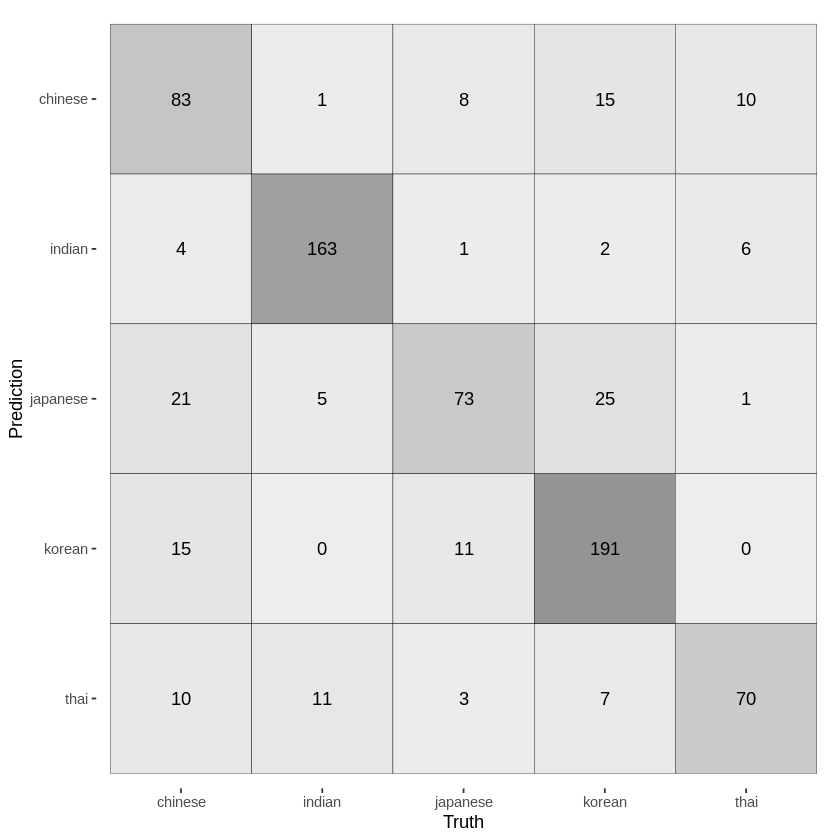

In [11]:
update_geom_defaults(geom = "tile", new = list(color = "black", alpha = 0.7))
# Visualize confusion matrix
results %>% 
  conf_mat(cuisine, .pred_class) %>% 
  autoplot(type = "heatmap")

Ang mas madidilim na mga parisukat sa plot ng confusion matrix ay nagpapahiwatig ng mataas na bilang ng mga kaso, at sana ay makita mo ang isang pahilis na linya ng mas madidilim na mga parisukat na nagpapakita ng mga kaso kung saan ang hinulaang label at aktwal na label ay magkapareho.

Ngayon, kalkulahin natin ang mga buod na istatistika para sa confusion matrix.


In [12]:
# Summary stats for confusion matrix
conf_mat(data = results, truth = cuisine, estimate = .pred_class) %>% 
summary()

.metric              .estimator .estimate
1  accuracy             multiclass 0.7880435
2  kap                  multiclass 0.7276583
3  sens                 macro      0.7780927
4  spec                 macro      0.9477598
5  ppv                  macro      0.7585583
6  npv                  macro      0.9460080
7  mcc                  multiclass 0.7292724
8  j_index              macro      0.7258524
9  bal_accuracy         macro      0.8629262
10 detection_prevalence macro      0.2000000
11 precision            macro      0.7585583
12 recall               macro      0.7780927
13 f_meas               macro      0.7641862

Kung tututok tayo sa ilang metrics tulad ng accuracy, sensitivity, at ppv, hindi naman masama ang simula natin 🥳!

## 4. Mas Malalim na Pagsusuri

Magtanong tayo ng isang maselan na tanong: Anong pamantayan ang ginagamit para pumili ng isang uri ng lutuin bilang hinulaang resulta?

Sa totoo lang, ang mga statistical machine learning algorithms, tulad ng logistic regression, ay nakabatay sa `probability`; kaya ang talagang hinuhulaan ng isang classifier ay isang probability distribution sa hanay ng mga posibleng resulta. Ang klase na may pinakamataas na probability ang pinipili bilang pinaka-malamang na resulta para sa ibinigay na mga obserbasyon.

Tingnan natin ito sa aktwal sa pamamagitan ng paggawa ng parehong hard class predictions at probabilities.


In [13]:
# Make hard class prediction and probabilities
results_prob <- cuisines_test %>%
  select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test)) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test, type = "prob"))

# Print out results
results_prob %>% 
  slice_head(n = 5)

cuisine .pred_class .pred_chinese .pred_indian .pred_japanese .pred_korean
1 indian  thai        1.551259e-03  0.4587877    5.988039e-04   2.428503e-04
2 indian  indian      2.637133e-05  0.9999488    6.648651e-07   2.259993e-05
3 indian  indian      1.049433e-03  0.9909982    1.060937e-03   1.644947e-05
4 indian  indian      6.237482e-02  0.4763035    9.136702e-02   3.660913e-01
5 indian  indian      1.431745e-02  0.9418551    2.945239e-02   8.721782e-03
  .pred_thai  
1 5.388194e-01
2 1.577948e-06
3 6.874989e-03
4 3.863391e-03
5 5.653283e-03

✅ Maaari mo bang ipaliwanag kung bakit sigurado ang modelong ito na ang unang obserbasyon ay Thai?

## **🚀Hamunin**

Sa araling ito, ginamit mo ang iyong nalinis na datos upang bumuo ng isang machine learning model na kayang hulaan ang pambansang lutuin batay sa isang serye ng mga sangkap. Maglaan ng oras upang basahin ang [maraming opsyon](https://www.tidymodels.org/find/parsnip/#models) na inaalok ng Tidymodels para sa pag-uuri ng datos at [ibang paraan](https://parsnip.tidymodels.org/articles/articles/Examples.html#multinom_reg-models) upang magkasya ang multinomial regression.

#### PASASALAMAT SA:

[`Allison Horst`](https://twitter.com/allison_horst/) para sa paggawa ng mga kamangha-manghang ilustrasyon na ginagawang mas kaaya-aya at nakakaengganyo ang R. Hanapin ang iba pang ilustrasyon sa kanyang [gallery](https://www.google.com/url?q=https://github.com/allisonhorst/stats-illustrations&sa=D&source=editors&ust=1626380772530000&usg=AOvVaw3zcfyCizFQZpkSLzxiiQEM).

[Cassie Breviu](https://www.twitter.com/cassieview) at [Jen Looper](https://www.twitter.com/jenlooper) para sa paggawa ng orihinal na bersyong Python ng modyul na ito ♥️

<br>
Gusto ko sanang magbiro pero hindi ko maintindihan ang mga food puns 😅.

<br>

Masayang Pag-aaral,

[Eric](https://twitter.com/ericntay), Gold Microsoft Learn Student Ambassador.



---

**Paunawa**:  
Ang dokumentong ito ay isinalin gamit ang AI translation service na [Co-op Translator](https://github.com/Azure/co-op-translator). Bagama't sinisikap naming maging tumpak, pakitandaan na ang mga awtomatikong pagsasalin ay maaaring maglaman ng mga pagkakamali o hindi pagkakatugma. Ang orihinal na dokumento sa kanyang orihinal na wika ang dapat ituring na opisyal na sanggunian. Para sa mahalagang impormasyon, inirerekomenda ang propesyonal na pagsasalin ng tao. Hindi kami mananagot sa anumang hindi pagkakaunawaan o maling interpretasyon na maaaring magmula sa paggamit ng pagsasaling ito.
